In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt

#os.environ["SPARK_LOCAL_IP"] = '127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()

[('spark.app.startTime', '1646815708896'),
 ('spark.app.id', 'local-1646815712225'),
 ('spark.driver.host', '127.0.0.1'),
 ('spark.driver.port', '54625'),
 ('spark.rdd.compress', 'True'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/love9/Desktop/python/MLOps-using-MLFlow/spark-warehouse'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

In [3]:
data_path = "data/creditcard.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [4]:
df.show(2)

# pyspark 자체적으로 데이터프레임을 생성할 순 있지만 가시성이 좋지 않음

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

In [5]:
df.toPandas().head()

# toPandas를 사용하면 쉽게 볼 수 있음

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
# 모델을 학습하기 위해 features라는 벡터를 전달해야 함
# 입력 데이터로부터 피처 벡터를 생성하는 벡터 어셈블러 정의
# 입력으로 사용할 컬럼을 features 컬럼?으로 포함시킴

stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

dfFeatures = df.select(F.col(labelColumn).alias('label'), *numericCols)

normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")
normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed=2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed=2020)

In [21]:
# pd.concat과 동일한 pyspark의 union 사용

train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

In [ ]:
# 처리 파이프라인 생성

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)
seletedCols = ['label', 'features'] + numericCols
train = train.select(seletedCols)
test = test.select(seletedCols)

print("Training Dataset Count :", train.count())
print("Test Dataset Count :", test.count())

In [9]:
# 앞서 분리해놨던 features와 label 컬럼을 각각 featuresCol, labelCol로 지정함

lr = LogisticRegressionPySpark(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

In [10]:
# 추론 모델의 transform == predict
# 추론 결과인 predictions에서 정답인 label과 추론값인 prediction 컬럼을 지정하여 collect로 데이터를 추출함

predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

In [11]:
print(f"AUC Score : {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score : {pyspark_auc_score:.3%}")
print(f"Accuracy Score : {accuracy:.3%}")

AUC Score : 94.044%
PySpark AUC Score : 98.247%
Accuracy Score : 99.898%


C:\Users\love9\anaconda3\envs\data\lib\site-packages\pyspark\sql\context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


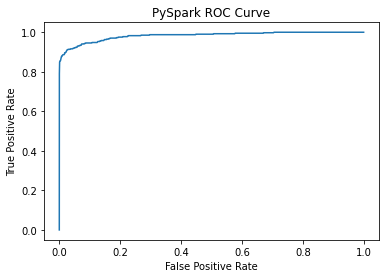

In [12]:
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("PySpark ROC Curve")
plt.plot(pyspark_roc["FPR"], pyspark_roc["TPR"])

Text(0.5, 15.0, 'Predicted')

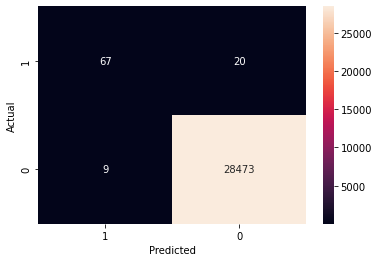

In [15]:
# pyspark의 기본 성능은 sklearn보다 좋음

conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel("Actual")
plt.xlabel("Predicted")